# **Stock Price Prediction**


*   In this project, we will be talking about predicting the returns on stocks. 
*   We will predict the stock price using the LSTM neural network.
*   The data contains records about the stock price of Tata Global Beverages Limited. The dataset also contains a date-wise price of stock with open, close, high, and low prices along with volume traded as well as turnover on that day.

### 1.    Imports

In [1]:
import os
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

2022-07-05 20:04:56.261124: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-05 20:04:56.264036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 20:04:56.264045: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 2. Connection to mysql server

In [19]:
# Set environment variables
os.environ['MYSQL_DB_USERNAME'] = input("Enter the username of the environment variable:")
os.environ['MYSQL_DB_PASSWORD'] = input("Enter the password of the environment variable:")

# Get environment variables
user_name = os.environ.get('MYSQL_DB_USERNAME')
password = os.environ.get('MYSQL_DB_PASSWORD')

In [3]:
# DEFINE THE DATABASE CREDENTIALS
user = user_name
password = password
host = 'localhost'
port = 3306
database = 'schema_2_'
  
# PYTHON FUNCTION TO CONNECT TO THE MYSQL DATABASE AND
engine= create_engine(url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))
connection=engine.connect()

## 3.   Read the dataset:

In [4]:
query = """SELECT * FROM schema_2_.Stock_Price_Predicton;"""

df = pd.read_sql(query, con=connection)

In [5]:
df.head()

,Date,Open,High,Low,Last,Close,Total_Trade_Quantity,Turnover_Lacs
0,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


 ## 4. Analyze the closing prices from dataframe:

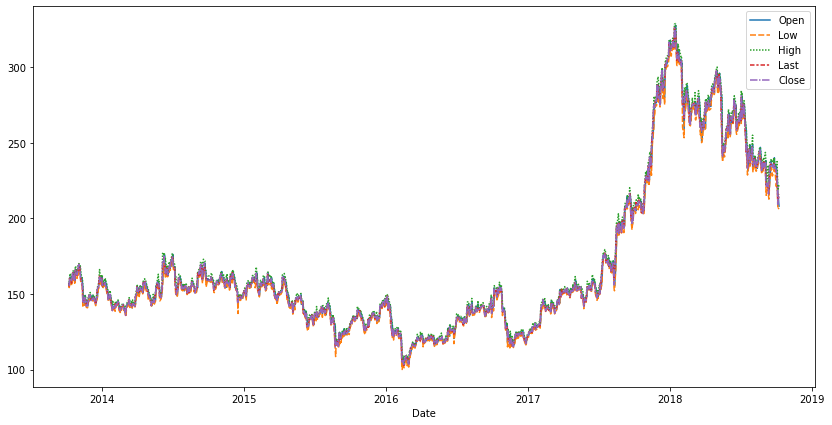

In [6]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.drop('Date', axis=1, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax = sns.lineplot(data=df[['Open', 'Low', 'High', 'Last', 'Close']])

## 5. dimensionality reduction: Drop features 

We will drop columns that are well correalated within the 'Close' column


In [7]:
df = df[ ['Close'] + [ col for col in df.columns if col != 'Close' ] ]
df.head()

,Close,Open,High,Low,Last,Total_Trade_Quantity,Turnover_Lacs
Date,,,,,,,
2013-10-08,155.80,157.00,157.80,155.20,155.8,1720413.0,2688.94
2013-10-09,155.55,155.70,158.20,154.15,155.3,2049580.0,3204.49
2013-10-10,160.15,156.00,160.80,155.85,160.3,3124853.0,4978.80
2013-10-11,160.05,161.15,163.45,159.00,159.8,1880046.0,3030.76
2013-10-14,159.45,160.85,161.45,157.70,159.3,1281419.0,2039.09


In [8]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

/tmp/ipykernel_13664/3250585738.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [9]:
# Drop features 
df=df.drop(df[to_drop], axis=1)
df.head()

,Close,Total_Trade_Quantity,Turnover_Lacs
Date,,,
2013-10-08,155.80,1720413.0,2688.94
2013-10-09,155.55,2049580.0,3204.49
2013-10-10,160.15,3124853.0,4978.80
2013-10-11,160.05,1880046.0,3030.76
2013-10-14,159.45,1281419.0,2039.09


### 6. Normalize the dataset:

In [10]:
df.drop(['Total_Trade_Quantity','Turnover_Lacs'],axis=1,inplace=True)

In [11]:
df.head()

,Close
Date,
2013-10-08,155.80
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [12]:
# prepare data for normalization
values =df.values
values = values.reshape((len(values), 1))

# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# normalize the dataset
normalized = scaler.transform(values)
 
# inverse transform 
inversed = scaler.inverse_transform(normalized)

# split & reshape   
train_size=int(0.8*len(df)) 
x_train_data,y_train_data=[],[]

for i in range(60,train_size):
    x_train_data.append(normalized[i-60:i,0])
    y_train_data.append(normalized[i,0])
    
x_train_data = np.array(x_train_data)
y_train_data = np.array(y_train_data)
print(x_train_data.shape)
print(y_train_data.shape)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
print(x_train_data.shape)

Min: 102.650000, Max: 325.750000
(928, 60)
(928,)
(928, 60, 1)


### 7. Build and train the LSTM model:

In [13]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(Dropout(0.3))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(1))


lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=1)
lstm_model.summary()

2022-07-05 20:05:20.451633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-05 20:05:20.451650: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 20:05:20.451662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Mohamed-HP-250-G8): /proc/driver/nvidia/version does not exist
2022-07-05 20:05:20.451865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


928/928 [==============================] - 11s 11ms/step - loss: 0.0020
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
______________________________________________

### 8. Preparing the test data.

In [14]:
test_data=df[train_size-60:].values
test_data=scaler.transform(test_data)

X_test=[]
for i in range(60,test_data.shape[0]):
    X_test.append(test_data[i-60:i,0])

X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(247, 60, 1)


### 9.Predicting the Values for test data

In [15]:
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 0s 7ms/step


### 10. Save the LSTM model:

In [16]:
lstm_model.save("saved_model.h5")

### 11. Visualize the predicted stock costs with actual stock costs:

/tmp/ipykernel_13664/1350529171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


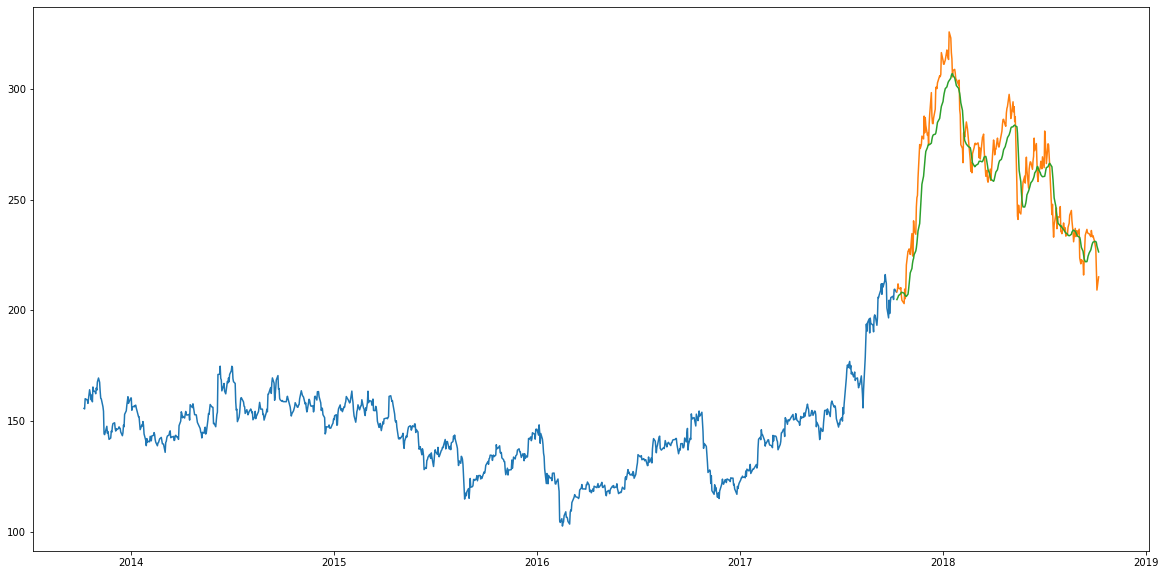

In [18]:
train_data=df[:train_size]
valid_data=df[train_size:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])